In [56]:
# %pip install tensorflow
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
#%pip install pydot
#%pip install pydot
#%pip install scipy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fabia\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fabia\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [57]:
# Dataset Validation & Cleaning

from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Hyperparameters
image_size = (64, 64)
batch_size = 32
epochs = 50

# Load Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

# Load Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 978 files belonging to 3 classes.
Using 783 files for training.
Found 978 files belonging to 3 classes.
Using 195 files for validation.


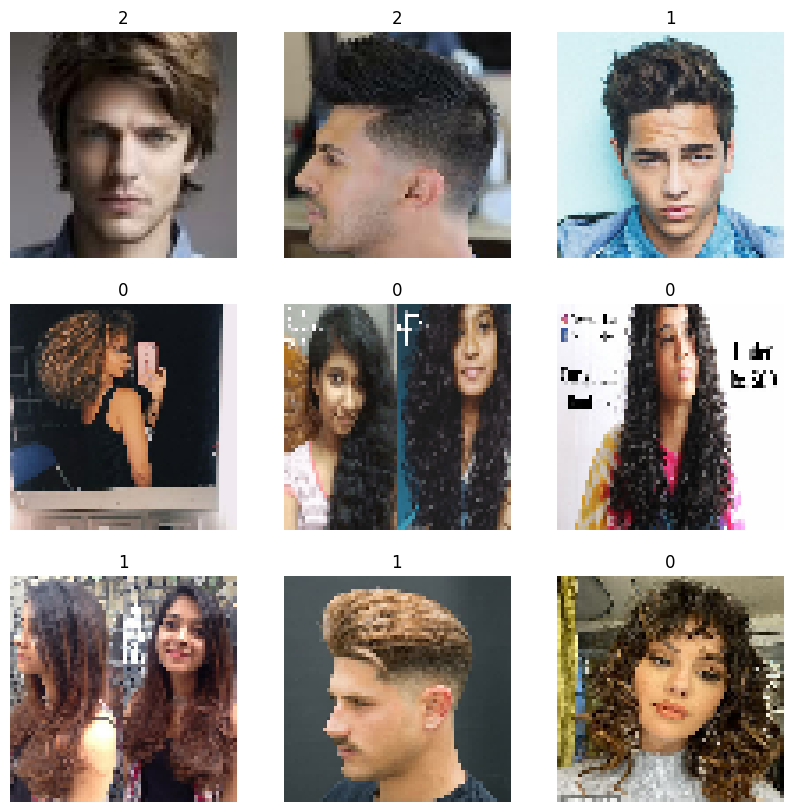

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers

# Define data augmentation function
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flip images vertically
    # image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness randomly
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast randomly
    #image = tf.image.rot90(image, tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)) # Randomly rotate the image by 0, 90, 180, or 270 degrees
    
    return image, label

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(augment_data)

# Define your model architecture
model = Sequential([
    keras.Input(shape=image_size + (3,)),
    layers.Rescaling(1.0 / 255),

    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),
    
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model with augmented data
model.fit(augmented_train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 354ms/step - accuracy: 0.3623 - loss: 1.2739 - val_accuracy: 0.3795 - val_loss: 1.2242
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.4848 - loss: 1.1643 - val_accuracy: 0.3385 - val_loss: 1.2155
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.4626 - loss: 1.1615 - val_accuracy: 0.3538 - val_loss: 1.2178
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.5216 - loss: 1.1155 - val_accuracy: 0.3333 - val_loss: 1.2725
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - accuracy: 0.5465 - loss: 1.0636 - val_accuracy: 0.3333 - val_loss: 1.2903
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - accuracy: 0.5445 - loss: 1.0525 - val_accuracy: 0.3282 - val_loss: 1.2646
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.5290 - loss: 1.0591 - val_accuracy: 0.3282 - val_loss: 1.3186
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.5818 - loss: 1.0274 - val_accur

KeyboardInterrupt: 

In [ ]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
This image is 0.96 percent curly hair, 0.03 percent straight hair, and 0.01 percent wavy hair.
